In [0]:
!rm -rf sample_data

In [0]:
# helper functions for pulling in data to colabs

def get_files_by_folder_id(folder_id, drive):
  return drive.ListFile(
    {'q': "'{}' in parents".format(folder_id)}).GetList()

def is_folder_prefix(folder_name, folders):
    return any(map(lambda x: x.startswith(folder_name), folders))

#recursively build the file directory at download_path for folder with download_id on drive
def build_file_directory(download_path, download_id, drive, folders=None):
  try:
    os.makedirs(download_path)
    #print('created', download_path)
  except: 
    #print('failed to create', download_path)

  file_list = get_files_by_folder_id(download_id, drive)
  
  for f in file_list:
    if f['mimeType'] == 'application/vnd.google-apps.folder':
      #print(folders)
      sub_download_path = download_path + '/' + f['title']
      #print(sub_download_path)
      
      #if sub_download_path is a prefix for any string in required folders, must explore
      if folders is None or is_folder_prefix(sub_download_path, folders):
        build_file_directory(download_path + '/' + f['title'], f['id'], drive, folders)
    else:
      #add files if the file is in a required folder (given by download_path)
      if download_path in folders:
       #print('title: %s, id: %s' % (f['title'], f['id']))
       fname = os.path.join(download_path, f['title'])
       #print('downloading to {}'.format(fname))
       f_ = drive.CreateFile({'id': f['id']})
       f_.GetContentFile(fname)
    
      
    
  

In [25]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_root = '/content/models'

local_download_path = os.path.expanduser(local_root)

#specify model imports we actually want
required_folders = ['official/mnist', 'research/gan/mnist', 'research/slim/datasets', 'research/gan/mnist/data']
required_local_paths = [local_root + '/' + folder_name for folder_name in required_folders]

print(required_local_paths)

#given id corresponds to models
build_file_directory(local_download_path, '17t5nYVve2Amzh1Rty5NnXsTQ2-1d9K6c', drive, required_local_paths)



['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data']
failed to create /content/models
['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data']
/content/models/tutorials
['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data']
/content/models/samples
['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data']
/content/models/.git
['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data']
/content/models/official
failed to create /content/models/official
['/content/models/official/mnist', '/co

In [4]:
default_path = 'models/research/gan'

os.listdir()
os.chdir(default_path)
os.listdir()

['mnist']

In [0]:
#os.chdir('..')

# TFGAN Tutorial

## Authors: Joel Shor, joel-shor

### More complex examples, see [`tensorflow/models/gan`](https://github.com/tensorflow/models/tree/master/research/gan)


This notebook will walk you through the basics of using [TFGAN](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/gan) to define, train, and evaluate Generative Adversarial Networks. We describe the library's core features as well as some extra features. This colab assumes a familiarity with TensorFlow's Python API. For more on TensorFlow, please see [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

Please note that running on GPU will significantly speed up the training steps, but is not required.

Last update: 2018-02-10.

## Table of Contents
<a href='#installation_and_setup'>Installation and Setup</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#download_data'>Download Data</a><br>
<a href='#unconditional_example'>Unconditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_train'>Train and evaluation</a><br>
<a href='#ganestimator_example'>GANEstimator example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_train'>Train</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_eval'>Eval</a><br>
<a href='#conditional_example'>Conditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_train'>Train and evaluation</a><br>
<a href='#infogan_example'>InfoGAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_train'>Train and evaluation</a><br>

<a id='installation_and_setup'></a>
## Installation and setup

To make sure that your version of TensorFlow has TFGAN included, run

```
python -c "import tensorflow.contrib.gan as tfgan"
```

You also need to install the TFGAN models library.

To check that these two steps work, execute the [`Imports`](#imports) cell. If it complains about unknown modules, restart the notebook after moving to the TFGAN models directory.

In [0]:
!python -c "import tensorflow.contrib.gan as tfgan"

In [0]:
# Make TFGAN models and TF-Slim models discoverable.
import sys
import os
# This is needed since the notebook is stored in the `tensorflow/models/gan` folder.
sys.path.append('..')
sys.path.append(os.path.join('..', 'slim'))

<a id='imports'></a>
### Imports

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf

# Main TFGAN library.
tfgan = tf.contrib.gan

# TFGAN MNIST examples from `tensorflow/models`.
from mnist import data_provider
from mnist import util

# TF-Slim data provider.
from datasets import download_and_convert_mnist

# Shortcuts for later.
queues = tf.contrib.slim.queues
layers = tf.contrib.layers
ds = tf.contrib.distributions
framework = tf.contrib.framework


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Common functions

These functions are used by many examples, so we define them here.

In [0]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')

def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

<a id='download_data'></a>
### Download data

In [0]:
MNIST_DATA_DIR = '/tmp/mnist-data'

if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

download_and_convert_mnist.run(MNIST_DATA_DIR)

>> Downloading 100.1%
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
>> Downloading 113.5%
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
>> Downloading 100.4%
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
>> Downloading 180.4%
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting images from:  /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting labels from:  /tmp/mnist-data/train-labels-idx1-ubyte.gz
>> Converting image 60000/60000Extracting images from:  /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting labels from:  /tmp/mnist-data/t10k-labels-idx1-ubyte.gz
>> Converting image 10000/10000

<a id='unconditional_example'></a>
# Unconditional GAN Example

With unconditional GANs, we want a generator network to produce realistic-looking digits. During training, the generator tries to produce realistic-enough digits to 'fool' a discriminator network, while the discriminator tries to distinguish real digits from generated ones. See the paper ['NIPS 2016 Tutorial: Generative Adversarial Networks'](https://arxiv.org/pdf/1701.00160.pdf) by Goodfellow or ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) by Goodfellow et al. for more details.

The steps to using TFGAN to set up an unconditional GAN, in the simplest case, are as follows:

1. **Model**: Set up the generator and discriminator graphs with a [`GANModel`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39) tuple. Use [`tfgan.gan_model`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L64) or create one manually.
1. **Losses**: Set up the generator and discriminator losses with a [`GANLoss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L115) tuple. Use [`tfgan.gan_loss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L328) or create one manually.
1. **Train ops**: Set up TensorFlow ops that compute the loss, calculate the gradients, and update the weights with a [`GANTrainOps`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) tuple. Use [`tfgan.gan_train_ops`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L476) or create one manually.
1. **Run alternating train loop**: Run the training Ops. This can be done with [`tfgan.gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661), or done manually.

Each step can be performed by a TFGAN library call, or can be constructed manually for more control.

<a id='unconditional_input'></a>
## Data input pipeline

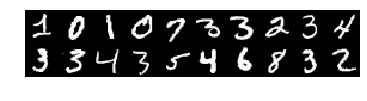

In [18]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

<a id='unconditional_model'></a>
## Model

Set up a [GANModel tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39), which defines everything we need to perform GAN training. You can create the tuple with the library functions, or you can manually create one.

Define the GANModel tuple using the TFGAN library function.
For the simplest case, we need the following:

1. A generator function that takes input noise and outputs generated MNIST digits

1. A discriminator function that takes images and outputs a probability of  being real or fake

1. Real images

1. A noise vector to pass to the generator

### Generator

In [0]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

### Discriminator

In [0]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

### GANModel Tuple

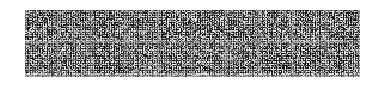

In [21]:
noise_dims = 64
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(check_generated_digits)

<a id='unconditional_loss'></a>
## Losses

We next set up the GAN model losses.

Loss functions are currently an active area of research. The [losses library](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/losses/python/losses_impl.py) provides some well-known or successful loss functions, such as the [original minimax](https://arxiv.org/abs/1406.2661), [Wasserstein](https://arxiv.org/abs/1701.07875) (by Arjovsky et al), and [improved Wasserstein](https://arxiv.org/abs/1704.00028) (by Gulrajani et al) losses. It is easy to add loss functions to the library as they are developed, and you can also pass in a custom loss function.

In [22]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -1.075753
vanilla loss discriminator loss: 1.526770
improved wgan loss generator loss: 0.597845
improved wgan loss discriminator loss: -0.001096
custom loss generator loss: 1.018970
custom loss discriminator loss: -0.067323


<a id='unconditional_train'></a>
## Training and Evaluation

### Train Ops
In order to train a GAN, we need to train both generator and discriminator networks using some variant of the alternating training paradigm. To do this, we construct a [GANTrainOps tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) either manually or with a library call. We pass it the optimizers that we want to use, as well as any extra arguments that we'd like passed to slim's `create_train_op` function.

In [23]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

TFGAN provides some standard methods of evaluating generative models. In this example, we use a pre-trained classifier to calculate what is called the 'Inception Score' from [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) (by Salimans et al), which is a combined score of quality and diversity. We also calculate the 'Frechet Inception distance' from [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) (by Heusel et al), which measures how close the generated image distribution is to the real image distribution. 

In [26]:
num_images_to_eval = 500

#this is a saved classifier
MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'

# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]),
        is_training=False)

# Calculate Inception score.
eval_score = util.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Calculate Frechet Inception distance.
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', num_images_to_eval, MNIST_DATA_DIR)
frechet_distance = util.mnist_frechet_distance(
    real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Reshape eval images for viewing.
generated_data_to_visualize = tfgan.eval.image_reshaper(
    eval_images[:20,...], num_cols=10)

Instructions for updating:
Use tf.cast instead.


In [0]:
#inception score probably just takes a classifier that already works on the right distribution 
#and sees how it does on this new distribution. Kind of like an analogy between probability
#and likelihood. The score represents... 

### Train Steps

Now we're ready to train. TFGAN handles the alternating training scheme that arises from the GAN minmax game. It also gives you the option of changing the ratio of discriminator updates to generator updates. Most applications (distributed setting, borg, etc) will use the [`gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661) function, but we will use a different TFGAN utility and manually run the train ops so we can introspect more.

This code block should take about **1 minute** to run on a GPU kernel, and about **8 minutes** on CPU.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Current loss: -0.304111
Current MNIST score: 1.000074
Current Frechet distance: 350.793060
Training step: 0
Time since start: 0.054891 m
Steps per min: 0.000000


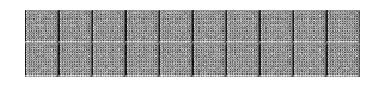

Current loss: -2.974410
Current MNIST score: 2.323987
Current Frechet distance: 172.578873
Training step: 200
Time since start: 0.217122 m
Steps per min: 921.140088


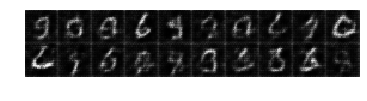

Current loss: -3.064900
Current MNIST score: 5.643053
Current Frechet distance: 47.538952
Training step: 400
Time since start: 0.378714 m
Steps per min: 1056.205700


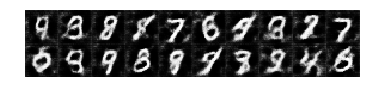

Current loss: -2.772895
Current MNIST score: 6.828274
Current Frechet distance: 35.941658
Training step: 600
Time since start: 0.540168 m
Steps per min: 1110.765402


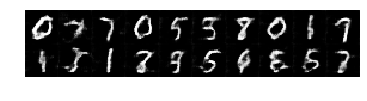

Current loss: -3.005592
Current MNIST score: 7.438951
Current Frechet distance: 23.132832
Training step: 800
Time since start: 0.700871 m
Steps per min: 1141.436347


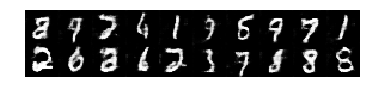

Current loss: -2.412736
Current MNIST score: 7.529320
Current Frechet distance: 45.006454
Training step: 1000
Time since start: 0.861546 m
Steps per min: 1160.703718


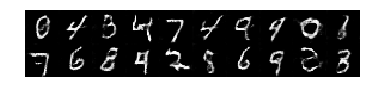

Current loss: -2.849480
Current MNIST score: 7.464315
Current Frechet distance: 34.874554
Training step: 1200
Time since start: 1.022244 m
Steps per min: 1173.888271


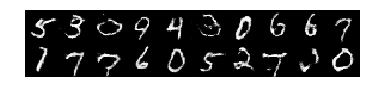

Current loss: -4.053162
Current MNIST score: 7.274474
Current Frechet distance: 39.519619
Training step: 1400
Time since start: 1.182601 m
Steps per min: 1183.830836


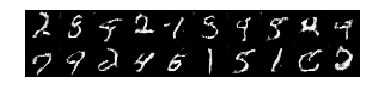

Current loss: -5.313146
Current MNIST score: 8.080517
Current Frechet distance: 12.604596
Training step: 1600
Time since start: 1.344073 m
Steps per min: 1190.411961


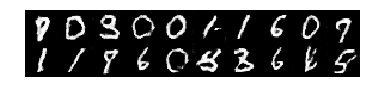

In [27]:
# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(1601):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 200 == 0:
            mnist_score, f_distance, digits_np = sess.run(
                [eval_score, frechet_distance, generated_data_to_visualize])
            mnist_scores.append((i, mnist_score))
            frechet_distances.append((i, f_distance))
            print('Current loss: %f' % cur_loss)
            print('Current MNIST score: %f' % mnist_scores[-1][1])
            print('Current Frechet distance: %f' % frechet_distances[-1][1])
            visualize_training_generator(i, start_time, digits_np)

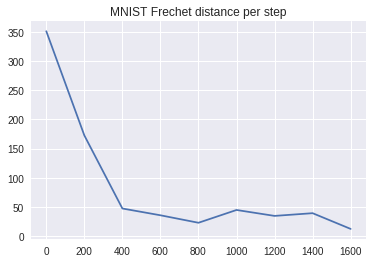

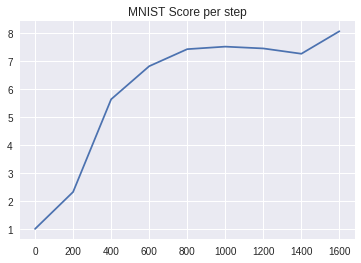

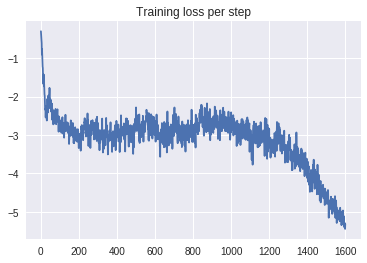

In [28]:
# Plot the eval metrics over time.
plt.title('MNIST Frechet distance per step')
plt.plot(*zip(*frechet_distances))
plt.figure()
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_scores))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))